In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import pytz
from pytz import timezone
import time

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
tz = timezone('US/Central') # This data uses GMT-6 rather than standard CST/CDT
def toUTC(d):
    return tz.normalize(tz.localize(d)).astimezone(pytz.utc)

In [24]:
def string2datetime(stringDTSeries):
    try:
        return [(dt.datetime.strptime(DT,'%Y/%m/%d %I:%M:%S %p')) for DT in stringDTSeries]
    except(ValueError):
        try:
            return [(dt.datetime.strptime(DT,'%Y/%m/%d %H:%M:%S')) for DT in stringDTSeries]
        except(ValueError):
            try:
                return [(dt.datetime.strptime(DT,'%m/%d/%Y %I:%M:%S %p')) for DT in stringDTSeries]
            except(ValueError):
                try:
                    return [(dt.datetime.strptime(DT,'%m/%d/%Y %H:%M:%S')) for DT in stringDTSeries]
                except(ValueError):
                    return [(dt.datetime.strptime(DT,'%m/%d/%y %H:%M:%S')) for DT in stringDTSeries]

In [2]:
path = '/Volumes/RTO/C Brace/GPS Analysis/' #mac
# path = 'X:/C Brace/GPS Analysis/' #win
# path = 'Z:/C Brace/GPS Analysis/'


# Calculate Features

In [3]:
path_procfiles = os.path.join(path,'UIC_GPSData/w_Steps')

In [4]:
def getTripDur(PreDestInd,Data):
    d = Data[PreDestInd]
    TripDur=[]
    for i in range(len(d)):
        if d['LandUse'].as_matrix()[i]=='Trip':
            TripDur.append(d['Duration'].as_matrix()[i])
        else:
            TripDur.append(np.float('nan'))
            
    return pd.Series(TripDur)

**Retrieve Home Data only**

In [5]:
Data = pd.DataFrame()
for f in os.listdir(path_procfiles):
#     print(f)
    if os.path.isfile(os.path.join(path_procfiles,f)):
        d = pd.read_csv(os.path.join(path_procfiles,f))
        d.LandUse = [x.split('_')[0] for x in d.LandUse]
        DestinationInd = d['LandUse']=='Home' #to retrieve home data
        # don't use first row as a destination
        if DestinationInd[0]:
            DestinationInd[0] = False
        
        del d['Unnamed: 0']
        del d['Unnamed: 0.1']
        d['SubjID'] = str(f[:5])
        d['Brace'] = str.capitalize(f[6:9])
        d = d[DestinationInd]
        Data = pd.concat([Data,d]) #concatenate data from each subj 
    else:
        #skip directories
        continue

In [6]:
Data=Data.drop('Unnamed: 0.1.1',axis=1)
Data.columns

Index(['Date', 'Sequence', 'BeginTime', 'EndTime', 'Mode', 'LandUse',
       'MeanSpeed', 'Numberpoints', 'TotalGap', 'Duration', 'Mean Lat',
       'Mean Lon', 'Wear Frac', 'Numpoints', 'Speed_Mean', 'Speed_Min',
       'Speed_Max', 'Speed_Median', 'Gap_Min', 'Gap_Max', 'Gap_Mean',
       'Gap_Median', 'LocID', 'DistHome', 'Steps', 'Steps per Hour',
       'Steps per Hour Wear', 'SubjID', 'Brace', 'MaximumSpeed',
       'MinimumSpeed'],
      dtype='object')

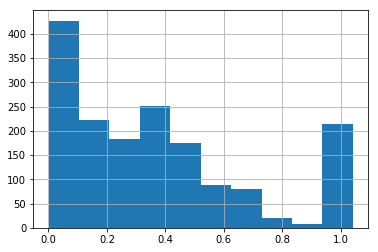

In [10]:
Data['Duration'].hist()

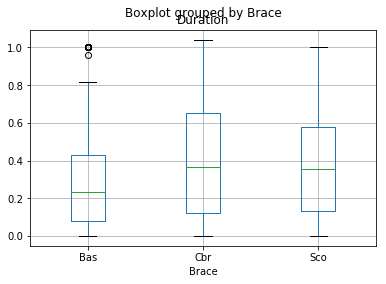

In [11]:
Data.boxplot(column='Duration',by='Brace')

In [12]:
#assign new brace category
Data['NewBrace']=0

In [13]:
for s in Data.SubjID.unique():
    print(s,Data[Data['SubjID']==s].Brace.unique())


CBR21 ['Cbr' 'Sco' 'Bas']
CBR30 ['Bas' 'Cbr' 'Sco']
CBR22 ['Cbr' 'Sco' 'Bas']
CBR24 ['Sco' 'Cbr' 'Bas']
CBR27 ['Sco' 'Bas' 'Cbr']
CBR26 ['Bas' 'Cbr' 'Sco']
CBR11 ['Cbr' 'Bas' 'Sco']
CBR16 ['Cbr' 'Sco']
CBR28 ['Cbr' 'Bas' 'Sco']
CBR31 ['Sco' 'Bas' 'Cbr']
CBR15 ['Cbr' 'Bas' 'Sco']
CBR19 ['Sco' 'Cbr' 'Bas']
CBR25 ['Cbr' 'Bas']
CBR08 ['Sco' 'Cbr']


In [14]:
Data=Data.reset_index(drop=True)
#add label of new brace
for s in Data.SubjID.unique():
    if len(Data[Data['SubjID']==s].Brace.unique()) > 2: #if baseline device data exists, assumes CBR and SCO are both the new brace
        Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Cbr'),'NewBrace']=1
        Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Sco'),'NewBrace']=1
    else: #if only SCO or Cbr data exists
        if 'Cbr' in Data[Data['SubjID']==s].Brace.unique():
            Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Cbr'),'NewBrace']=1    
        else:
            Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Sco'),'NewBrace']=1    
            

In [15]:
#To remove SCO data (for speed analysis) if 3 devices exist
for s in Data.SubjID.unique():
    if len(Data[Data['SubjID']==s].Brace.unique()) > 2: #if baseline device data exists, assumes CBR and SCO are both the new brace
        inds= np.where((Data['SubjID']==s) & (Data['Brace']=='Sco'))[0]
        Data=Data.drop(inds)
        Data=Data.reset_index(drop=True)
len(Data)  

1303

In [16]:
for s in Data.SubjID.unique():
    print(s,Data[Data['SubjID']==s].Brace.unique())


CBR21 ['Cbr' 'Bas']
CBR30 ['Bas' 'Cbr']
CBR22 ['Cbr' 'Bas']
CBR27 ['Bas' 'Cbr']
CBR26 ['Bas' 'Cbr']
CBR11 ['Cbr' 'Bas']
CBR16 ['Cbr' 'Sco']
CBR28 ['Cbr' 'Bas']
CBR15 ['Cbr' 'Bas']
CBR25 ['Cbr' 'Bas']
CBR19 ['Cbr' 'Bas']
CBR08 ['Sco' 'Cbr']
CBR24 ['Cbr' 'Bas']
CBR31 ['Bas' 'Cbr']


In [17]:
Features = pd.DataFrame({'Wear Frac':np.array(Data['Wear Frac'])})

In [18]:
Features['Duration'] = (Data['Duration']*24).as_matrix()
Features['Mean Speed'] = Data['Speed_Mean'].as_matrix()
Features['SubjID'] = Data['SubjID'].as_matrix()
Features['NewBrace'] = Data['NewBrace'].as_matrix()
Features['LocID'] = Data['LocID'].as_matrix()
Features['Steps'] = Data['Steps'].as_matrix()
Features['Steps per Hour'] = Data['Steps per Hour'].as_matrix()
Features['Steps per Hour Wear'] = Data['Steps per Hour Wear'].as_matrix()
Features['Date'] = Data['Date'].as_matrix()

In [19]:
demographics = pd.read_excel('./Demographics_analysis.xlsx')
Features['Age'] = [demographics[demographics['SubjID']==x]['Age'].values[0] for x in Data['SubjID']]
Features['Diagnosis'] = [demographics[demographics['SubjID']==x]['Short Diagnosis'].values[0] for x in Data['SubjID']]
Features['BaselineYrs'] = [demographics[demographics['SubjID']==x]['y of baseline use'].values[0] for x in Data['SubjID']]
ClinicalMeasures = ['6mwt', '10mwt_ss', '10mwt_fast']
for name in ClinicalMeasures:
    d = pd.read_csv('./Clinical Measures/'+name+'.csv')
    Features[name] = [d[d['SubjID']==x][y].values[0] for x, y in Data[['SubjID', 'Brace']].as_matrix()]

In [20]:
Features.to_csv('GPSandClinicalData_Home.csv',index=False)

In [72]:
Data.columns

Index(['BeginTime', 'Brace', 'Date', 'DistHome', 'Duration', 'EndTime',
       'Gap_Max', 'Gap_Mean', 'Gap_Median', 'Gap_Min', 'LandUse', 'LocID',
       'MaximumSpeed', 'Mean Lat', 'Mean Lon', 'MeanSpeed', 'MinimumSpeed',
       'Mode', 'Numberpoints', 'Numpoints', 'Sequence', 'Speed_Max',
       'Speed_Mean', 'Speed_Median', 'Speed_Min', 'SubjID', 'TotalGap',
       'Wear Frac', 'NewBrace'],
      dtype='object')

**Retrieve Destinations data only**

In [29]:
Data = pd.DataFrame()
for f in os.listdir(path_procfiles):
#     print(f)
    if os.path.isfile(os.path.join(path_procfiles,f)):
        d = pd.read_csv(os.path.join(path_procfiles,f))
        d.LandUse = [x.split('_')[0] for x in d.LandUse]
        DestinationInd = (d['LandUse']!='Home')&(d['LandUse']!='Trip')
        # don't use first row as a destination
        if DestinationInd[0]:
            DestinationInd[0] = False
        
        del d['Unnamed: 0']
        del d['Unnamed: 0.1']
        d['SubjID'] = str(f[:5])
        d['Brace'] = str.capitalize(f[6:9])
        
#         print(sum(DestinationInd), sum(d['LandUse']=='Trip'))
        
        # Calculate trip features
        PreDestInd = DestinationInd[1::]
        PreDestInd = PreDestInd.append(pd.Series(False)).as_matrix()
#         print(d[PreDestInd]['LandUse'].unique())

#         TripMode = pd.Series(np.float('nan')).append(d[PreDestInd]['Mode'])
        TripMode = d[PreDestInd]['Mode']
#         TripDuration = pd.Series(np.float('nan')).append(getTripDur(PreDestInd,d))
        TripDuration = getTripDur(PreDestInd,d)
        
        # Calculate aggregate features
        d = d[DestinationInd]
        d['Relative Freq'] = pd.Series([sum(d['LocID']==x)/sum(DestinationInd) for x in d['LocID']]).as_matrix()
        d['Relative Duration'] = pd.Series([sum(d[d['LocID']==x]['Duration'])/sum(d['Duration']) for x in d['LocID']]).as_matrix()
#         print(np.sum(np.unique(d['Relative Duration'])))
        d['TripMode'] = TripMode.as_matrix()
        d['TripDuration'] = TripDuration.as_matrix()
        Data = pd.concat([Data,d]) #concatenate data from each subj
    else:
        #skip directories
        continue

OtherDestInd = (Data['LandUse']!='Inst')&(Data['LandUse']!='Res')&(Data['LandUse']!='Com')&(Data['LandUse']!='Os')
Data.loc[OtherDestInd,'LandUse'] = 'Other'

In [30]:
newbrace = 'Cbr'
for s in Data.SubjID.unique():
    Data_ = Data[(Data['SubjID']==s)&(Data['Brace']==newbrace)]
    print(s,np.sum(np.unique(Data_['Relative Duration'])),len(np.unique(Data_['Relative Duration'])), len(np.unique(Data_['LocID'])))


CBR21 1.0 39 39
CBR30 0.997640757508 82 83
CBR22 0.999185655695 28 29
CBR24 1.0 20 20
CBR27 0.0 0 0
CBR26 0.990781177716 30 33
CBR11 0.996556359807 52 57
CBR16 0.997422727858 30 31
CBR28 1.0 4 4
CBR31 0.995418374729 19 20
CBR15 1.0 11 11
CBR19 1.0 4 4
CBR25 1.0 12 12
CBR08 0.992913777914 24 25


In [31]:
Data.columns

Index(['BeginTime', 'Brace', 'Date', 'DistHome', 'Duration', 'EndTime',
       'Gap_Max', 'Gap_Mean', 'Gap_Median', 'Gap_Min', 'LandUse', 'LocID',
       'MaximumSpeed', 'Mean Lat', 'Mean Lon', 'MeanSpeed', 'MinimumSpeed',
       'Mode', 'Numberpoints', 'Numpoints', 'Relative Duration',
       'Relative Freq', 'Sequence', 'Speed_Max', 'Speed_Mean', 'Speed_Median',
       'Speed_Min', 'Steps', 'Steps per Hour', 'Steps per Hour Wear', 'SubjID',
       'TotalGap', 'TripDuration', 'TripMode', 'Unnamed: 0.1.1', 'Wear Frac'],
      dtype='object')

In [32]:
Data.Sequence.unique()

array([ 3,  5,  7, 11,  9, 13,  1, 15,  6,  8, 10, 12, 14,  2,  4, 16, 18,
       20, 22, 17, 19, 21, 23, 25, 29, 27, 31, 35, 33, 37, 39, 26, 28, 30,
       32, 34, 36, 40, 44, 41, 43, 45, 47, 49, 24, 38])

In [33]:
Datacopy = Data.copy()

In [34]:
Data=Datacopy.copy()

In [35]:
Data=Data.reset_index(drop=True)
Data.head()
print(len(Data))

2653


In [36]:
#assign new brace category
Data['NewBrace']=0

In [37]:
for s in Data.SubjID.unique():
    print(s,Data[Data['SubjID']==s].Brace.unique())


CBR21 ['Cbr' 'Sco' 'Bas']
CBR30 ['Bas' 'Cbr' 'Sco']
CBR22 ['Cbr' 'Sco' 'Bas']
CBR24 ['Sco' 'Cbr' 'Bas']
CBR27 ['Sco' 'Bas']
CBR26 ['Bas' 'Cbr' 'Sco']
CBR11 ['Cbr' 'Bas' 'Sco']
CBR16 ['Cbr' 'Sco']
CBR28 ['Cbr' 'Bas' 'Sco']
CBR31 ['Sco' 'Bas' 'Cbr']
CBR15 ['Cbr' 'Bas' 'Sco']
CBR19 ['Sco' 'Cbr' 'Bas']
CBR25 ['Cbr' 'Bas']
CBR08 ['Sco' 'Cbr']


In [38]:
#add label of new brace
for s in Data.SubjID.unique():
#     print(Data[Data['SubjID']==s].Brace.unique())
    if len(Data[Data['SubjID']==s].Brace.unique()) > 2: #if baseline device data exists, assumes CBR and SCO are both the new brace
        Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Cbr'),'NewBrace']=1
        Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Sco'),'NewBrace']=1
    else: #if only SCO or Cbr data exists
        if 'Cbr' in Data[Data['SubjID']==s].Brace.unique():
            Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Cbr'),'NewBrace']=1    
        else:
            Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Sco'),'NewBrace']=1    
            

In [39]:
#To remove SCO data (for speed analysis) if 3 devices exist
for s in Data.SubjID.unique():
    if len(Data[Data['SubjID']==s].Brace.unique()) > 2: #if baseline device data exists, assumes CBR and SCO are both the new brace
        inds= np.where(((Data['SubjID']==s) & (Data['Brace']=='Sco')))[0]
        Data=Data.drop(inds)
        Data=Data.reset_index(drop=True)
len(Data)  

2181

In [40]:
for s in Data.SubjID.unique():
    print(s,Data[Data['SubjID']==s].Brace.unique())


CBR21 ['Cbr' 'Bas']
CBR30 ['Bas' 'Cbr']
CBR22 ['Cbr' 'Bas']
CBR27 ['Sco' 'Bas']
CBR26 ['Bas' 'Cbr']
CBR11 ['Cbr' 'Bas']
CBR16 ['Cbr' 'Sco']
CBR28 ['Cbr' 'Bas']
CBR15 ['Cbr' 'Bas']
CBR25 ['Cbr' 'Bas']
CBR19 ['Cbr' 'Bas']
CBR08 ['Sco' 'Cbr']
CBR24 ['Cbr' 'Bas']
CBR31 ['Bas' 'Cbr']


In [104]:
Data.to_csv('GPSData.csv',index=False)

In [47]:
Features = pd.DataFrame({'Wear Frac':np.array(Data['Wear Frac'])})

In [48]:
Features['DestinationType'] = Data['LandUse'].as_matrix()
Features['Distance'] = (Data['DistHome']/1000).as_matrix()
Features['Duration'] = (Data['Duration']*24).as_matrix()
Features['Mean Speed'] = Data['Speed_Mean'].as_matrix()
# Features['TripMode'] = Data['TripMode'].as_matrix()
Features['TripDuration'] = Data['TripDuration'].as_matrix()
Features['Relative_Freq'] = Data['Relative Freq'].as_matrix()
Features['Relative_Duration'] = Data['Relative Duration'].as_matrix()
Features['SubjID'] = Data['SubjID'].as_matrix()
# Features['Brace'] = Data['Brace'].as_matrix()
Features['NewBrace'] = Data['NewBrace'].as_matrix()
Features['Steps'] = Data['Steps'].as_matrix()
Features['Steps per Hour'] = Data['Steps per Hour'].as_matrix()
Features['Steps per Hour Wear'] = Data['Steps per Hour Wear'].as_matrix()
Features['Date'] = Data['Date'].as_matrix()

In [49]:
demographics = pd.read_excel('./Demographics_analysis.xlsx')
demographics.columns

Index(['SubjID', 'median WT CBR', 'median WT SCO', 'median WT Baseline',
       'med sph CBR', 'med sph SCO', 'med sph Baseline', 'y of baseline use',
       'Diagnosis', 'Short Diagnosis', 'Age', 'Ncluster CBR',
       'MeanAwayTime CBR', 'Away/Home Time CBR', 'Home_WT CBR', 'Away_WT CBR',
       'Ncluster SCO', 'MeanAwayTime SCO', 'Away/Home Time SCO', 'Home_WT SCO',
       'Away_WT SCO'],
      dtype='object')

In [50]:
Features['Age'] = [demographics[demographics['SubjID']==x]['Age'].values[0] for x in Data['SubjID']]
Features['Diagnosis'] = [demographics[demographics['SubjID']==x]['Short Diagnosis'].values[0] for x in Data['SubjID']]
Features['BaselineYrs'] = [demographics[demographics['SubjID']==x]['y of baseline use'].values[0] for x in Data['SubjID']]


In [51]:
ClinicalMeasures = ['6mwt', '10mwt_ss', '10mwt_fast']
for name in ClinicalMeasures:
    d = pd.read_csv('./Clinical Measures/'+name+'.csv')
    Features[name] = [d[d['SubjID']==x][y].values[0] for x, y in Data[['SubjID', 'Brace']].as_matrix()]

In [52]:
#threshold max distance and bin age
Features.loc[Features['Distance']>1000,'Distance'] = 1000
# bin age
# bins = [0, 30, 64, 80]
# group_names = ['0-30', '30-64', '64+']
# Age_binned = pd.cut(Features['Age'], bins, labels=group_names)
# Features['Age']=Age_binned
# pd.value_counts(Features['Age'],normalize=True)

In [112]:
#convert nan to unknown category for Tripmode
# ind = Features['TripMode'].isnull()
# Features.loc[ind,'TripMode']='unknown'

In [113]:
#conver wear frac to binary 
# Features.loc[Features['Wear Frac']>.5,'Wear Frac'] = 1
# Features.loc[Features['Wear Frac']<.5,'Wear Frac'] = 0

In [53]:
#add lat and lon
Features['Mean Lat'] = Data['Mean Lat'].as_matrix()
Features['Mean Lon'] = Data['Mean Lon'].as_matrix()
Features['LocID'] = Data['LocID'].as_matrix()

In [54]:
Features.head()

,Wear Frac,DestinationType,Distance,Duration,Mean Speed,TripDuration,Relative_Freq,Relative_Duration,SubjID,NewBrace,...,Date,Age,Diagnosis,BaselineYrs,6mwt,10mwt_ss,10mwt_fast,Mean Lat,Mean Lon,LocID
0,0.015000,Res,12.229512,2.772222,0.215601,0.017824,0.014925,0.021452,CBR21,1,...,2016-08-18,65,poliomyelitis,60.0,231.93,0.69,0.85,41.732207,-88.132441,2
1,0.063091,Inst,6.302016,1.758333,0.230411,0.011921,0.014925,0.013607,CBR21,1,...,2016-08-18,65,poliomyelitis,60.0,231.93,0.69,0.85,41.783632,-88.188553,3
2,0.000000,Com,5.095353,1.016389,0.591493,0.008218,0.014925,0.007865,CBR21,1,...,2016-08-19,65,poliomyelitis,60.0,231.93,0.69,0.85,41.765985,-88.206360,4
3,0.000000,Com,5.172335,0.366111,1.607549,0.001505,0.029851,0.004252,CBR21,1,...,2016-08-19,65,poliomyelitis,60.0,231.93,0.69,0.85,41.760925,-88.208135,5
4,0.000000,Com,2.871296,0.052778,4.483316,0.003704,0.044776,0.001827,CBR21,1,...,2016-08-19,65,poliomyelitis,60.0,231.93,0.69,0.85,41.760981,-88.242395,6


In [55]:
Features.to_csv('GPSandClinicalData.csv',index=False)

In [56]:
len(Features)

2181

In [303]:
#use only data from new brace
# Features = Features[Features['NewBrace']==1]
# len(Features)

In [304]:
#save features
Features.to_csv('GPSmodelFeatures_2braceonly.csv',index=False)

# Explore features

In [305]:
#load features
# Features = pd.read_csv('GPSmodelFeatures.csv')
Features = pd.read_csv('GPSmodelFeatures_2braceonly.csv')
Features.head()

,Wear Frac,DestinationType,Distance,Duration,Mean Speed,TripDuration,Relative_Freq,Relative_Duration,SubjID,NewBrace,Age,Diagnosis,BaselineYrs,6mwt,10mwt_ss,10mwt_fast
0,0.0,Inst,6.302016,1.758333,0.230411,0.011921,0.014925,0.013607,CBR21,1,64+,poliomyelitis,60.0,231.93,0.69,0.85
1,0.0,Com,5.095353,1.016389,0.591493,0.008218,0.014925,0.007865,CBR21,1,64+,poliomyelitis,60.0,231.93,0.69,0.85
2,0.0,Com,5.172335,0.366111,1.607549,0.001505,0.029851,0.004252,CBR21,1,64+,poliomyelitis,60.0,231.93,0.69,0.85
3,0.0,Com,2.871296,0.052778,4.483316,0.003704,0.044776,0.001827,CBR21,1,64+,poliomyelitis,60.0,231.93,0.69,0.85
4,0.0,Com,2.870687,0.033333,7.098997,0.004514,0.044776,0.001827,CBR21,1,64+,poliomyelitis,60.0,231.93,0.69,0.85


### Does Clinical speed (10mWT) affect wear time and role of brace

In [306]:
F = Features[['SubjID','NewBrace','10mwt_ss','Wear Frac']]

In [307]:
F.head()

,SubjID,NewBrace,10mwt_ss,Wear Frac
0,CBR21,1,0.69,0.0
1,CBR21,1,0.69,0.0
2,CBR21,1,0.69,0.0
3,CBR21,1,0.69,0.0
4,CBR21,1,0.69,0.0


In [309]:
Wf = pd.DataFrame(data=None,columns=['SubjID','NewBrace','Avg_WearFrac','10mwt_ss'])
for s in F.SubjID.unique():
    for brace in F.NewBrace.unique():
               
        d_s = F.loc[(F['SubjID']==s) & (F['NewBrace']==brace),['Wear Frac','10mwt_ss']]
        wf_s = d_s['Wear Frac'].values
        wf_s = np.sum(wf_s)/len(wf_s) #compute average wear time fraction over all locations
    
        d = {'SubjID':s, 'NewBrace':brace ,'Avg_WearFrac':wf_s, '10mwt_ss':d_s['10mwt_ss'].unique()}
     
        Wf=Wf.append(pd.DataFrame(d),ignore_index=True) 
    

In [313]:
Wf.head()

,10mwt_ss,Avg_WearFrac,NewBrace,SubjID
0,0.69,0.030303,1,CBR21
1,0.70,0.630952,0,CBR21
2,1.20,0.936416,1,CBR30
3,0.99,0.983607,0,CBR30
4,1.00,0.840000,1,CBR22


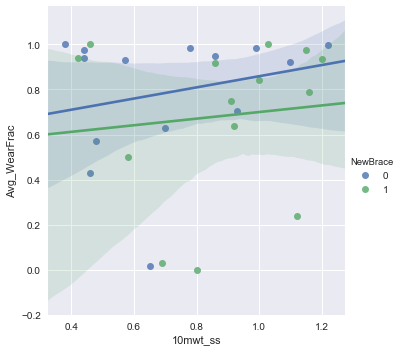

In [311]:
sns.lmplot(data=Wf,x='10mwt_ss',y='Avg_WearFrac',hue='NewBrace') #binarized weartime

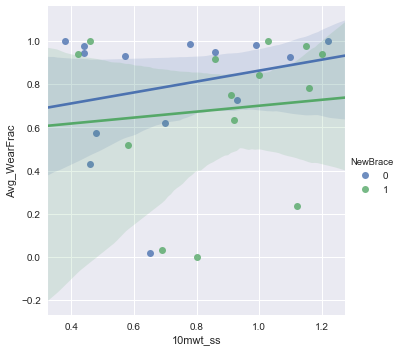

In [284]:
sns.lmplot(data=Wf,x='10mwt_ss',y='Avg_WearFrac',hue='NewBrace')

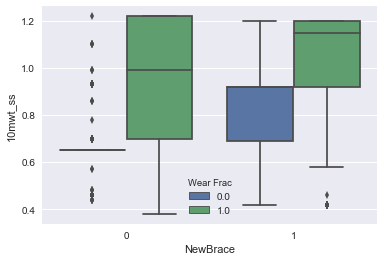

In [312]:
sns.boxplot(data=F,x='NewBrace',y='10mwt_ss',hue='Wear Frac')

## Explore features

In [6]:
Features.columns

Index(['Wear Frac', 'DestinationType', 'Distance', 'Duration', 'Mean Speed',
       'TripDuration', 'Relative_Freq', 'Relative_Duration', 'SubjID',
       'NewBrace', 'Age', 'Diagnosis', 'BaselineYrs', '6mwt', '10mwt_ss',
       '10mwt_fast'],
      dtype='object')

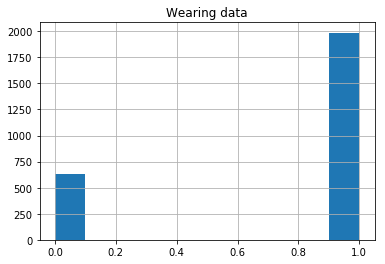

In [7]:
Features['Wear Frac'].hist()
plt.title('Wearing data')

In [8]:
np.sort(Features[Features['Wear Frac']==0].SubjID.unique())

array(['CBR08', 'CBR11', 'CBR15', 'CBR19', 'CBR21', 'CBR22', 'CBR24',
       'CBR25', 'CBR26', 'CBR27', 'CBR28', 'CBR30', 'CBR31'], dtype=object)

In [9]:
#instances for each subject having wear frac = 0
for s in np.sort(Features[Features['Wear Frac']==0].SubjID.unique()):

    print(s,len(Features[(Features['SubjID']==s) & (Features['Wear Frac']==0)]))#/len(Features[Features['SubjID']==s]))

CBR08 51
CBR11 324
CBR15 16
CBR19 5
CBR21 156
CBR22 20
CBR24 23
CBR25 2
CBR26 3
CBR27 1
CBR28 3
CBR30 14
CBR31 11


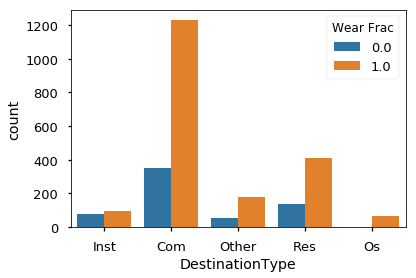

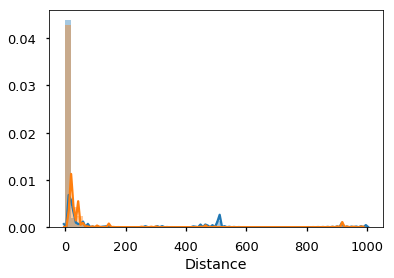

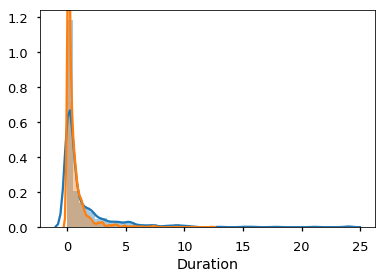

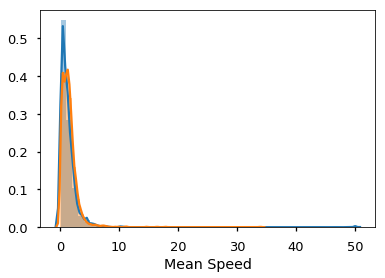

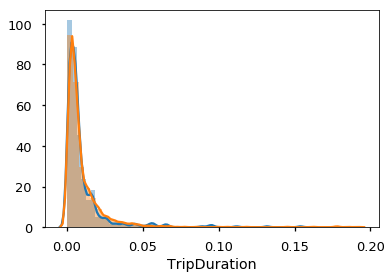

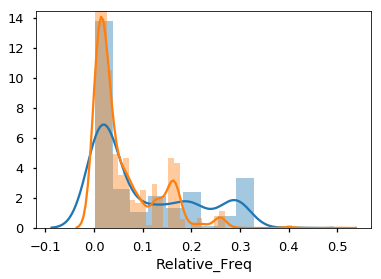

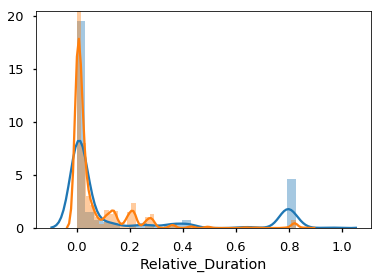

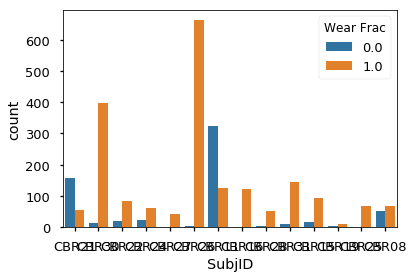

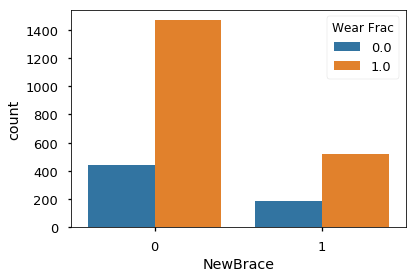

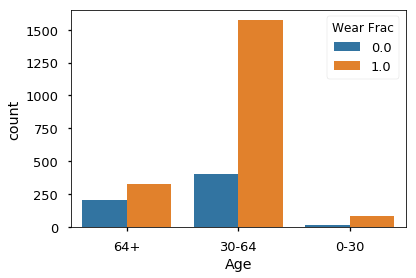

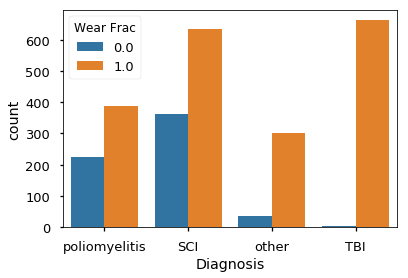

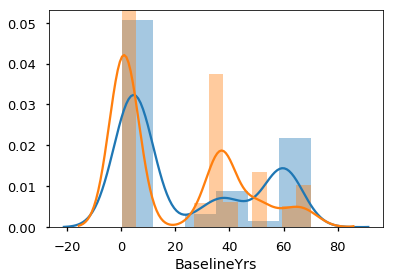

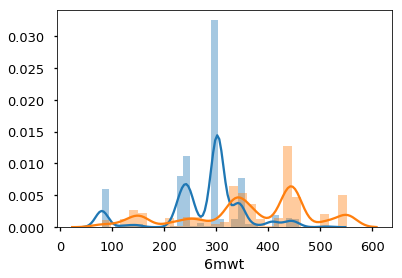

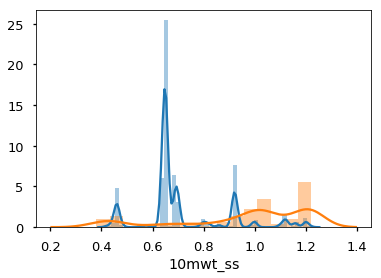

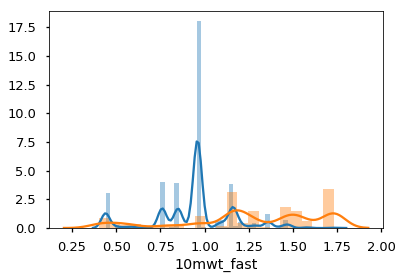

In [13]:
sns.set_context('talk')
f = Features.columns.values
f = list(f)[1:]
dtypesf = list(Features.dtypes[1:]) 
ft = zip(f,dtypesf)

for feat,ftyp in ft:
    fig = plt.figure()
    if ftyp is np.dtype('float64'):
        ind = ~(Features.loc[Features['Wear Frac']==0,feat].isnull()) #non-null values
        sns.distplot(Features[Features['Wear Frac']==0][ind][feat])
        ind = ~(Features.loc[Features['Wear Frac']==1,feat].isnull()) #non-null values
        sns.distplot(Features[Features['Wear Frac']==1][ind][feat])
#         sns.distplot(Features.loc[Features['Wear Frac']==0,feat])
#         sns.distplot(Features.loc[Features['Wear Frac']==1,feat])
# #         ax = Features.hist(column=feat,by='Wear Frac',layout=(1,2))
#         ax[0].set_xlabel(feat)
    else:
        sns.countplot(data=Features,x=feat,hue='Wear Frac')
    

# Train model

1) xgb – this is the direct xgboost library. I will use a specific function “cv” from this library

2) XGBClassifier – this is an sklearn wrapper for XGBoost. This allows us to use sklearn’s Grid Search with parallel processing in the same way we did for GBM

XGB package intro http://xgboost.readthedocs.io/en/latest/python/python_intro.html

Python API https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting

Feature importance example (in R) http://xgboost.readthedocs.io/en/latest/R-package/discoverYourData.html#feature-importance


## convert categorical vars into numeric ones using one-hot encoding
* Alternatively we could use [numerical vals conversion](https://chrisalbon.com/machine-learning/convert_pandas_categorical_column_into_integers_for_scikit-learn.html)

In [6]:
#drop SubjID from features table
cols = list(Features.columns)
cols.remove('SubjID')
SubjID = Features.SubjID
Features = Features.drop('SubjID',axis=1)

In [7]:
# # #convert using numerical encoding
FeaturesNum = Features.copy()
from sklearn.preprocessing import LabelEncoder
# Create a label (category) encoder object
enc = LabelEncoder()
cat_cols=Features.columns[(Features.dtypes == object) | (Features.dtypes == 'category')]
for c in cat_cols:
    FeaturesNum[c] = enc.fit_transform(FeaturesNum[c])
    print(c,np.unique(FeaturesNum[c]),enc.inverse_transform(np.unique(FeaturesNum[c])))

FeaturesNum.head()

DestinationType [0 1 2 3 4] ['Com' 'Inst' 'Os' 'Other' 'Res']
Age [0 1 2] ['0-30' '30-64' '64+']
Diagnosis [0 1 2 3] ['SCI' 'TBI' 'other' 'poliomyelitis']


,Wear Frac,DestinationType,Distance,Duration,Mean Speed,TripDuration,Relative_Freq,Relative_Duration,NewBrace,Age,Diagnosis,BaselineYrs,6mwt,10mwt_ss,10mwt_fast
0,0.0,1,6.302016,1.758333,0.230411,0.011921,0.014925,0.013607,1,2,3,60.0,231.93,0.69,0.85
1,0.0,0,5.095353,1.016389,0.591493,0.008218,0.014925,0.007865,1,2,3,60.0,231.93,0.69,0.85
2,0.0,0,5.172335,0.366111,1.607549,0.001505,0.029851,0.004252,1,2,3,60.0,231.93,0.69,0.85
3,0.0,0,2.871296,0.052778,4.483316,0.003704,0.044776,0.001827,1,2,3,60.0,231.93,0.69,0.85
4,0.0,0,2.870687,0.033333,7.098997,0.004514,0.044776,0.001827,1,2,3,60.0,231.93,0.69,0.85


In [8]:
# # #convert using one-hot encoding
# FeaturesNum = pd.get_dummies(Features)
# FeaturesNum.head()

In [9]:
FeaturesNum.columns

Index(['Wear Frac', 'DestinationType', 'Distance', 'Duration', 'Mean Speed',
       'TripDuration', 'Relative_Freq', 'Relative_Duration', 'NewBrace', 'Age',
       'Diagnosis', 'BaselineYrs', '6mwt', '10mwt_ss', '10mwt_fast'],
      dtype='object')

In [10]:
target = 'Wear Frac'
predictors = [x for x in FeaturesNum.columns if x not in target]

In [11]:
len(predictors)

14

## Features correlation (numerical)

In [12]:
Features[predictors].dtypes

DestinationType       object
Distance             float64
Duration             float64
Mean Speed           float64
TripDuration         float64
Relative_Freq        float64
Relative_Duration    float64
NewBrace               int64
Age                   object
Diagnosis             object
BaselineYrs          float64
6mwt                 float64
10mwt_ss             float64
10mwt_fast           float64
dtype: object

In [13]:
fnum = Features.drop(['NewBrace','Diagnosis','DestinationType','Age'],axis=1)

In [14]:
fnum = fnum.apply(lambda x: (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))  )

In [47]:
fcorr=fnum.corr()

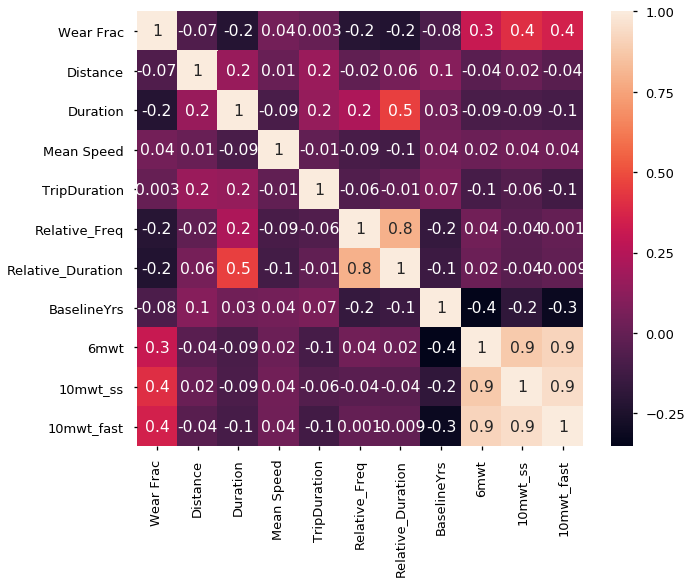

In [60]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(fcorr,annot=True,fmt='.1g')

## Top-5 Feature values for wear and non wear

In [190]:
top5

Duration        81.142857
10mwt_ss        80.500000
Distance        73.071429
TripDuration    72.928571
Mean Speed      70.285714
dtype: float64

In [208]:
FeaturesNum.head()

,Wear Frac,DestinationType,Distance,Duration,Mean Speed,TripDuration,Relative_Freq,Relative_Duration,NewBrace,Age,Diagnosis,BaselineYrs,6mwt,10mwt_ss,10mwt_fast
0,0.0,1,6.302016,1.758333,0.230411,0.011921,0.014925,0.013607,1,2,3,60.0,231.93,0.69,0.85
1,0.0,0,5.095353,1.016389,0.591493,0.008218,0.014925,0.007865,1,2,3,60.0,231.93,0.69,0.85
2,0.0,0,5.172335,0.366111,1.607549,0.001505,0.029851,0.004252,1,2,3,60.0,231.93,0.69,0.85
3,0.0,0,2.871296,0.052778,4.483316,0.003704,0.044776,0.001827,1,2,3,60.0,231.93,0.69,0.85
4,0.0,0,2.870687,0.033333,7.098997,0.004514,0.044776,0.001827,1,2,3,60.0,231.93,0.69,0.85


In [262]:
top5f = FeaturesNum[top5.index].copy()
top5f.loc[top5f['Distance']>200,'Distance']=200

In [308]:
fnorm.head()

,Duration,10mwt_ss,Distance,TripDuration,Mean Speed,Wear Frac
0,0.073171,0.369048,0.031464,0.062247,0.004607,0.0
1,0.042247,0.369048,0.025430,0.042889,0.011827,0.0
2,0.015144,0.369048,0.025815,0.007804,0.032144,0.0
3,0.002084,0.369048,0.014309,0.019297,0.089648,0.0
4,0.001274,0.369048,0.014306,0.023532,0.141951,0.0


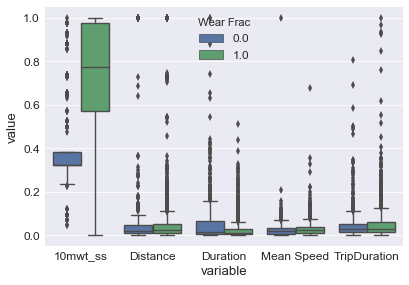

In [325]:
fnorm = top5f.copy() 
fnorm = fnorm.apply(lambda x: (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))  ) #rescale features between 0 and 1
fnorm[target] = FeaturesNum[target]
fnorm[target]=fnorm[target].astype('category')
fnorm=pd.melt(fnorm, id_vars=target, value_vars=set(fnorm.columns)-set([target]))
ax = sns.boxplot(data=fnorm,x='variable',y='value',hue=target)

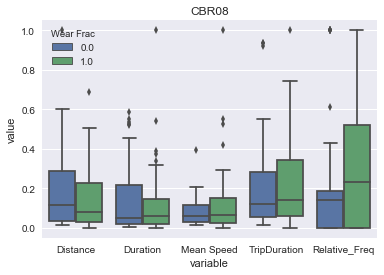

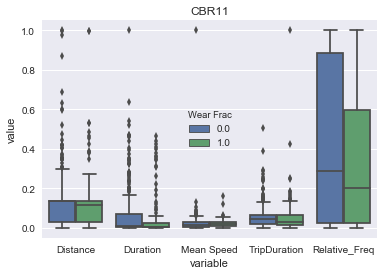

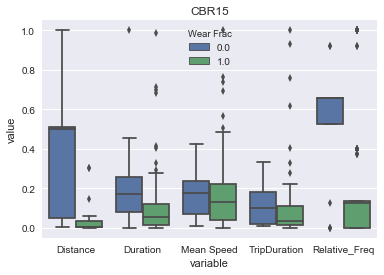

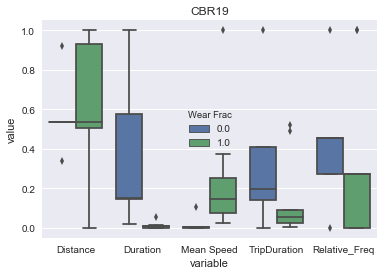

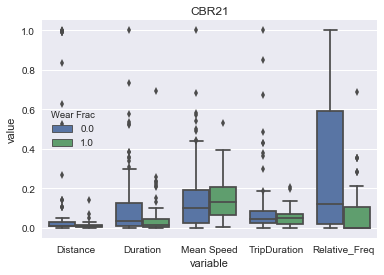

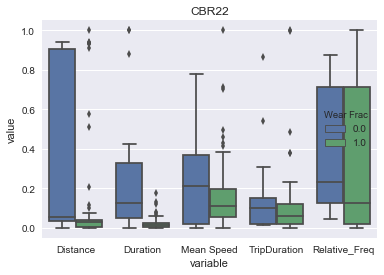

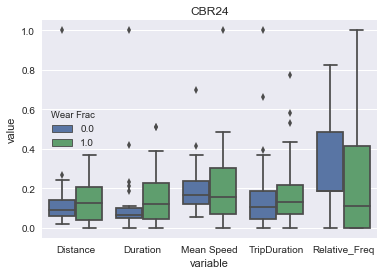

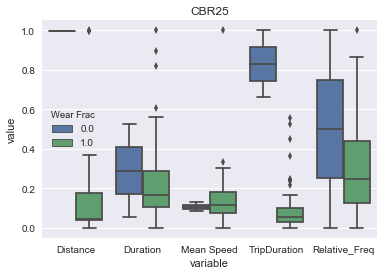

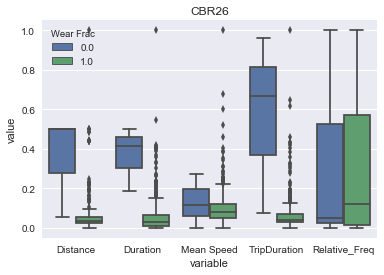

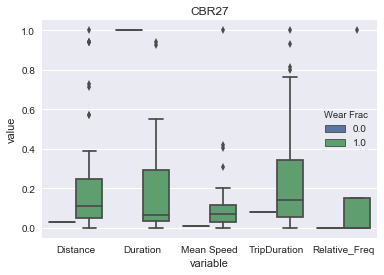

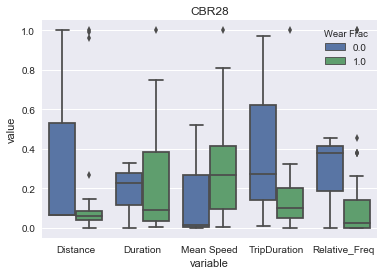

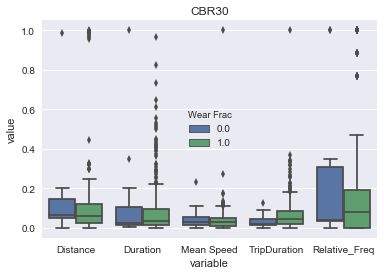

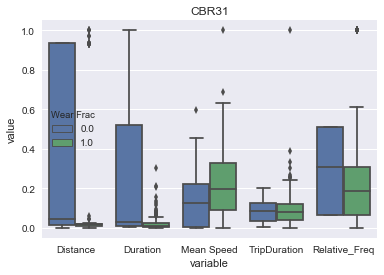

In [19]:
target='Wear Frac'
for s in np.sort(Features.SubjID.unique()):
    plt.figure()
    fnorm = Features.copy()
    fnorm=fnorm[fnorm.SubjID==s]
    fnorm[target]=fnorm[target].astype('category')
    if len(fnorm[target].unique()) < 2:
        continue
    fnorm=fnorm.drop(['DestinationType','Diagnosis','Age','SubjID'],axis=1)
    fnorm = fnorm.apply(lambda x: (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))  )
    fnorm=pd.melt(fnorm, id_vars='Wear Frac', value_vars=['Distance','Duration','Mean Speed','TripDuration','Relative_Freq'])
    ax = sns.boxplot(data=fnorm,x='variable',y='value',hue=target)
    ax=plt.title(str(s))

# Do people travel further from home with the cbrace?
* Median distance from home with each brace

In [208]:
#plot test datapoint
import gmplot
gmap = gmplot.GoogleMapPlotter(41.75554804, -87.91244198, 16)
gmap.scatter([home[0],home[0]],[home[1],home[1]],'#3B0B39', size=100,marker=False)
gmap.draw("mymap.html")

In [541]:
??gmplot.GoogleMapPlotter

In [ ]:
#store distance of each location visited from home
distall = pd.Series()
for s in Data.SubjID.unique():
    
    #mean lat,lon home for subj
    homelat = Data[(Data['SubjID']==s)&(Data['LandUse']=='Home')]['Mean Lat'].mean()
    homelon = Data[(Data['SubjID']==s)&(Data['LandUse']=='Home')]['Mean Lon'].mean()
    Datai = Data.loc[Data['SubjID']==s]            
    print(s)
    #distance of all locations from home
    d = []
    for k in range(len(Datai)):
        lat = Datai.iloc[k]['Mean Lat']
        lon = Datai.iloc[k]['Mean Lon']
        try:
            d.append(vincenty((homelat,homelon),(lat,lon)).meters/1000)
        except(UnboundLocalError): #nan lat,lon
            print('found nan lat/lon')
            d.append(np.nan)
     
    print(len(d))
    
    #aggregate distances for all subjects
    distall = distall.append(pd.Series(data=d,index=Data.loc[Data['SubjID']==s]['SubjID']))

In [90]:
#assigning new index to df Data to match with Series
Data.index = distall.index
Data['DistanceHome'] = distall

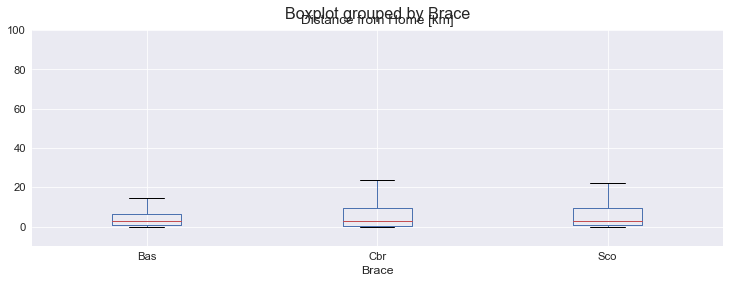

In [103]:
#plot distance from home for locations based on brace
ax2 = Data[~((Data['LandUse']=='Home')&(Data['LandUse']=='Trip'))].boxplot(column='DistanceHome',by='Brace',figsize=(12,4))
ax2.set_ylim([-10,100])
ax2.set_title('Distance from Home [km]')

## Distance traveled from home with each brace

In [ ]:
ax2 = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']=='Cbr')&(Data['Wear Frac']>0.75)].boxplot(column='DistanceHome',by=['SubjID'],figsize=(12,4))
ax2.set_ylim([-10,100])
ax2 = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']=='Cbr')&(Data['Wear Frac']<0.5)].boxplot(column='DistanceHome',by=['SubjID'],figsize=(12,4))
ax2.set_ylim([-10,100])

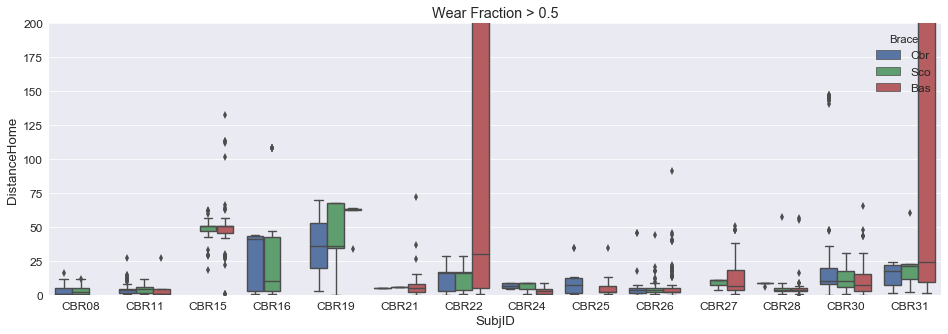

In [203]:
Datalocs = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Wear Frac']>0.5)]
fig = plt.figure(figsize=(16,5))
# fig.add_subplot(211)
ax = sns.boxplot(x='SubjID',y='DistanceHome',hue='Brace',data=Datalocs)
ax.set_ylim([0,200])
plt.title('Wear Fraction > 0.5')
sns.set_context('paper',font_scale=1.5)

# Datalocs = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Wear Frac']<0.5)]
# fig.add_subplot(212)
# ax = sns.boxplot(x='SubjID',y='DistanceHome',hue='Brace',data=Datalocs)
# ax.set_ylim([0,200])
# plt.title('Wear Fraction < 0.5')
# sns.set_context('paper',font_scale=1.5)

In [289]:
#plot locations visited by CBR22 and 31
s = 'CBR22'
d = Data.loc[(Data['SubjID']==s)]#&(~(Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))]
homelat = d[d['LandUse']=='Home']['Mean Lat'].mean()
homelon = d[d['LandUse']=='Home']['Mean Lon'].mean()
gmap = gmplot.GoogleMapPlotter(homelat, homelon, 16)

In [290]:
d = Data.loc[(Data['SubjID']==s)&(~(Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']=='Cbr')]
for l in range(len(d)):
    lat = d.iloc[l]['Mean Lat']
    lon = d.iloc[l]['Mean Lon']
    ll = np.array([lat,lon])
    gmap.scatter([ll[0],ll[0]],[ll[1],ll[1]],'#3B0B39', size=200,marker=False)

gmap.draw("mymap.html")

# distinct locations visited per brace

In [11]:
fconv =  os.listdir(path+'GPSWT/')

for f in fconv:
    print(f)
    Data = pd.read_csv(path+'UIC_GPSData/w_LatLonWear/'+f)
    # needs to be capitalized to standardize text
    landuse=Data[['LandUse']]
    landuse=landuse.applymap(lambda x: str.capitalize(x))
    Data['LandUse'] = landuse
    
    # find mean Home location
    HomeInd = Data['LandUse']=='Home'
    HomeLon = np.nanmean(Data['Mean Lon'][HomeInd])
    HomeLat = np.nanmean(Data['Mean Lat'][HomeInd])
    
    # identify unique locations (>100m apart)
    
    threshold = 50
    
    UnDestLon = []
    UnDestLat = []
    UnDestDist = []
    
    LocID = []
    DistHome = []
    
    for row in range(len(Data)):
        if (Data['LandUse'][row]!='Home')&(Data['LandUse'][row]!='Trip'): # should be non-Home, non-Trip
            lon = Data['Mean Lon'][row]
            lat = Data['Mean Lat'][row]
            d = vincenty((HomeLat,HomeLon),(lat,lon)).meters
            DistHome.append(d)
            if d<=threshold:
                # Ideally, d threshold should be small enough to separate locations near home
                # Flag failures to do this for now to see how often it happens
                print('Error: Non-Home Destination Near Home')
                print(Data['LandUse'][row])
                print(d)
                LocID.append(-2)
            else:
                if len(UnDestLon)<1: # Initial destination
                    UnDestLon.append(lon); UnDestLat.append(lat)
                    LocID.append(1)
                else: # After first location is ID'd check to see if other destinations are unique
                    i = 0; Unlabeled = True
                    while Unlabeled & (i<len(UnDestLat)):
                        d = vincenty((UnDestLat[i],UnDestLon[i]),(lat,lon)).meters
                        if d<=threshold:
                            Unlabeled = False
                            LocID.append(i+1)
                            # may want to consider adjusting mean location for the destination based on new trip
                        else:
                            i=i+1
                    if i==len(UnDestLat):
                        UnDestLon.append(lon); UnDestLat.append(lat); UnDestDist.append(d)
                        LocID.append(i+1)
        else:
            # Special cases for Home and Trip data
            if Data['LandUse'][row]=='Home':
                LocID.append(0)
                DistHome.append(0)
            else:
                LocID.append(-1)
                DistHome.append(-1)
                
    Data['LocID'] = pd.Series(LocID)
    Data['DistHome']  = pd.Series(DistHome)
    
    Data.to_csv(path+'UIC_GPSData/w_LocIDandDist/'+f)
                    
                            
                        
                    
    

CBR08_CBrace.csv
CBR08_SCO.csv
CBR11_Baseline.csv
CBR11_CBrace.csv
CBR11_SCO.csv
CBR15_Baseline.csv
CBR15_CBrace.csv
CBR15_SCO.csv
CBR16_CBrace.csv
CBR16_SCO.csv
CBR19_Baseline.csv
CBR19_CBrace.csv
CBR19_SCO.csv
Error: Non-Home Destination Near Home
Com_regional
9.55765950374758
CBR21_Baseline.csv
CBR21_CBrace.csv
CBR21_SCO.csv
CBR22_Baseline.csv
CBR22_CBrace.csv
CBR22_SCO.csv
CBR24_Baseline.csv
CBR24_CBrace.csv
CBR24_SCO.csv
CBR25_Baseline.csv
CBR25_CBrace.csv
CBR26_Baseline.csv
CBR26_CBrace.csv
CBR26_SCO.csv
CBR27_Baseline.csv
CBR27_CBrace.csv
CBR27_SCO.csv
CBR28_Baseline.csv
CBR28_CBrace.csv
CBR28_SCO.csv
CBR30_Baseline.csv
CBR30_CBrace.csv
CBR30_SCO.csv
CBR31_Baseline.csv
CBR31_CBrace.csv
CBR31_SCO.csv
